In [1]:
import pystac
from pystac import Link, Asset
from datetime import datetime

In [2]:
from pystac.extensions.label import LabelExtension
from pystac.extensions.label import LabelType
from pystac.extensions.label import LabelClasses
from pystac.extensions.label import LabelStatistics

from pystac.extensions.version import ItemVersionExtension

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [4]:
aws_url = "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_10TFK_20220524_0_L2A"

In [5]:
source_item = pystac.read_file(aws_url)

source_item

id: S2A_10TFK_20220524_0_L2A
"bbox: [-121.8343226741975, 39.63588071728383, -120.51956282559038, 40.64479052153662]"
datetime: 2022-05-24T19:03:29Z
platform: sentinel-2a
constellation: sentinel-2
instruments: ['msi']
gsd: 10
view:off_nadir: 0
proj:epsg: 32610
sentinel:utm_zone: 10
sentinel:latitude_band: T


In [15]:
source_item.get_assets()['SCL'].

href: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/10/T/FK/2022/5/S2A_10TFK_20220524_0_L2A/SCL.tif
type: image/tiff; application=geotiff; profile=cloud-optimized
title: Scene Classification Map (SCL)
roles: ['data']
owner: S2A_10TFK_20220524_0_L2A
"proj:shape: [5490, 5490]"
"proj:transform: [20, 0, 600000, 0, -20, 4500000, 0, 0, 1]"


TypeError: Image data of dtype object cannot be converted to float

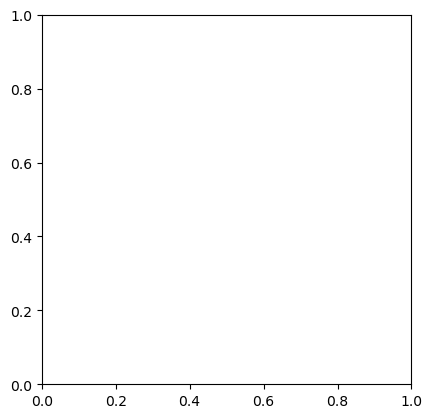

In [14]:
# Show SCL band
plt.figure()
plt.imshow(source_item.get_assets()['SCL'])
plt.show()

In [16]:
label_item = pystac.Item(
    id="label_{}".format("lu"),
    geometry=source_item.geometry,
    bbox=source_item.bbox,
    datetime=datetime.utcnow(),
    properties={},
)

In [17]:
label_classes = {
    "NO_DATA": 0,
    "SATURATED_OR_DEFECTIVE": 1,
    "CAST_SHADOWS": 2,
    "CLOUD_SHADOWS": 3,
    "VEGETATION": 4,
    "NOT_VEGETATED": 5,
    "WATER": 6,
    "UNCLASSIFIED": 7,
    "CLOUD_MEDIUM_PROBABILITY": 8,
    "CLOUD_HIGH_PROBABILITY": 9,
    "THIN_CIRRUS": 10,
    "SNOW or ICE": 11,
}

In [18]:
label = LabelExtension.ext(label_item, add_if_missing=True)
label.apply(
    label_description="Land cover labels",
    label_type=LabelType.VECTOR,
    label_tasks=["segmentation", "regression"],
    label_classes=[LabelClasses(label_classes)],
    label_methods=["manual"],
    label_properties=["class"],
)
label.add_source(source_item=source_item)
label.add_geojson_labels("labels-v1.geojson")

In [19]:
version = ItemVersionExtension(label_item)

version.apply(version="0.1", deprecated=False)

label_item.stac_extensions.append(
    "https://stac-extensions.github.io/version/v1.2.0/schema.json"
)

In [20]:
pystac.write_file(label_item, dest_href="label-item.json")

In [21]:
ml_aoi_item = pystac.Item(
    id="ml-aoi",
    geometry=source_item.geometry,
    bbox=source_item.bbox,
    datetime=datetime.utcnow(),
    properties={"ml-aoi:split": "train"},
)

In [25]:
ml_aoi_item.add_link(
    Link(
        rel="derived_from",
        target=aws_url,
        extra_fields={"ml-aoi:role": "feature"},
    )
)

ml_aoi_item.add_link(
    Link(
        rel="derived_from",
        target="label-item.json",
        extra_fields={"role": "ml-aoi:label"},
    )
)

In [26]:
label_asset = Asset(
    href="labels-v1.geojson",
    description="label",
    media_type=pystac.MediaType.GEOJSON,
    roles=["label"],
    extra_fields={"ml-aoi:role": "label"},
)

ml_aoi_item.add_asset(key="label", asset=label_asset)

In [27]:
ml_aoi_item.stac_extensions = [
    "https://stac-extensions.github.io/ml-aoi/v0.1.0/schema.json"
]

In [28]:
pystac.write_file(ml_aoi_item, dest_href="ml-aoi-item.json")